In [178]:
from IPython import display

In [179]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import evalys
from evalys.jobset import JobSet

# Obteniendo los archivos a analizar

In [180]:
schedule_names = ['fcfs', 'backfill']

In [181]:
schedule_files = []
jobs_files = []
for folders in os.listdir('../output/'):
    for files in os.listdir('../output/' + folders):
        if files.endswith('_schedule.csv'):
            schedule_files.append(folders + "/" +  files)
        elif files.endswith('_jobs.csv'):
            jobs_files.append(folders + "/" + files)

schedule_files = [os.path.join('../output', str(file)) for file in sorted(schedule_files)]
jobs_files = [os.path.join('../output', str(file)) for file in sorted(jobs_files)]
print(schedule_files)
print(jobs_files)

['../output/backfill/base_backfill_schedule.csv', '../output/fcfs/base_fcfs_schedule.csv']
['../output/backfill/base_backfill_jobs.csv', '../output/fcfs/base_fcfs_jobs.csv']


In [182]:
metrics = pd.DataFrame()
for file in schedule_files:
    _, schedule_name, _ = os.path.basename(file).split('_')
    if schedule_name in schedule_names:
        print("reading", file)
        df = pd.read_csv(file)
        df['schedule'] = schedule_name
        metrics = metrics.append(df)
metrics.set_index('schedule', inplace=True)

reading ../output/backfill/base_backfill_schedule.csv
reading ../output/fcfs/base_fcfs_schedule.csv


In [183]:
jobsets = {}
for file in jobs_files:
    _, schedule_name, _ = os.path.basename(file).split('_')
    if schedule_name in schedule_names:
        print("reading", file)
        jobsets[schedule_name] = JobSet.from_csv(file)

reading ../output/backfill/base_backfill_jobs.csv
reading ../output/fcfs/base_fcfs_jobs.csv


In [184]:
def calculate_compute_utilisation(schedule):
    compute_time = jobsets[schedule].df[['execution_time', 'requested_number_of_resources']].apply(lambda row: row.execution_time * row.requested_number_of_resources, axis=1).sum()
    return compute_time / (metrics.loc[schedule].makespan * 96)

def calculate_storage_utilisation(schedule):
    storage_time = jobsets[schedule].df[['execution_time', 'metadata']].apply(lambda row: row.execution_time * row.metadata, axis=1).sum()
    burst_buffer_capacity = 5 * 10**9
    num_burst_buffers = 12
    total_storage_time = metrics.loc[schedule].makespan * num_burst_buffers * burst_buffer_capacity
    return storage_time / total_storage_time

def create_metric_df(metric):
    return pd.concat([jobsets[schedule].df[metric].rename(schedule) for schedule in schedule_names], axis=1)

In [185]:
def bounded_slowdown(df):
    return (df.turnaround_time / df.execution_time.clip(lower=60)).clip(lower=1)

def create_all_metrics_df():
    dfs = []
    for schedule in schedule_names:
        df = jobsets[schedule].df
        df = df.assign(schedule=schedule).assign(bounded_slowdown=bounded_slowdown(df))[['schedule', 'waiting_time', 'turnaround_time', 'stretch']]
        dfs.append(df)
    df = pd.concat(dfs, axis=0).rename({'stretch': 'slowdown'}, axis=1)
    return df

In [186]:
metrics['compute_utilisation'] = pd.Series({schedule: calculate_compute_utilisation(schedule) for schedule in schedule_names})
metrics['storage_utilisation'] = pd.Series({schedule: calculate_storage_utilisation(schedule) for schedule in schedule_names})

In [187]:
metrics = metrics.reindex(schedule_names)
metrics.index.rename(None, inplace=True)
# sns.set_theme(context='talk', style='whitegrid')
sns.set_theme(style='whitegrid')

In [188]:
metrics.T

,fcfs,backfill
batsim_version,4.0.0,4.0.0
consumed_joules,0,0
makespan,759973,759973
max_slowdown,356936,356936
max_turnaround_time,759920,759920
max_waiting_time,759660,759660
mean_slowdown,11766.2,11766.2
mean_turnaround_time,254509,254509
mean_waiting_time,244211,244211
nb_computing_machines,4,4


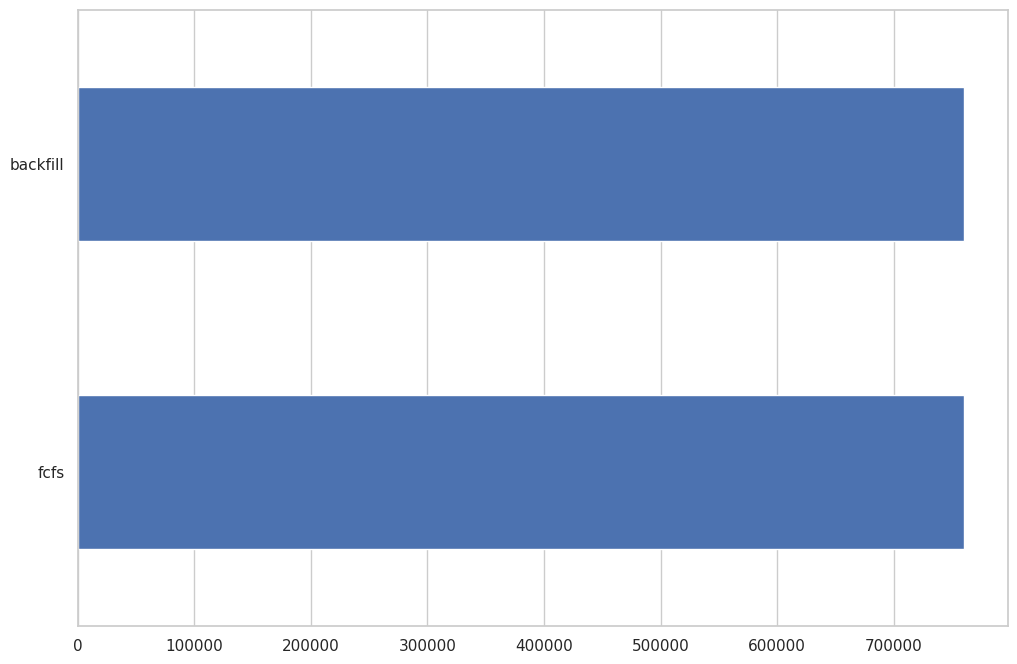

In [189]:
ax = metrics['makespan'].plot.barh(figsize=(12, 8))
ax.grid(axis='y')

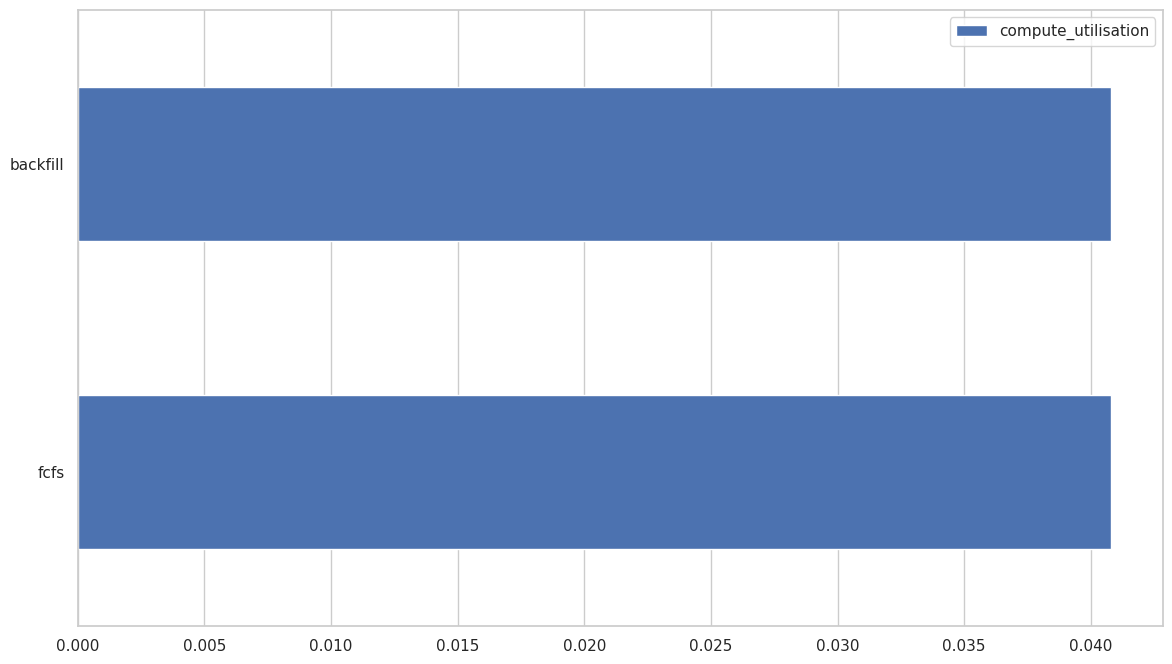

In [190]:
ax = metrics[['compute_utilisation']].plot.barh(figsize=(14, 8))
ax.grid(axis='y')

In [191]:
metrics_df = create_all_metrics_df()
metrics_df

,schedule,waiting_time,turnaround_time,slowdown
0,fcfs,1.000045,5.672068,1.214050
1,fcfs,0.500075,9.819606,1.053659
2,fcfs,0.500045,8.110268,1.065707
3,fcfs,10.821612,4028.450590,1.002694
4,fcfs,6.174038,5235.931963,1.001181
...,...,...,...,...
75,backfill,735248.268443,741971.052178,110.366640
76,backfill,741970.554148,756287.269146,52.825475
77,backfill,756286.771131,759660.583371,225.163859
78,backfill,759660.084659,759678.662888,40890.799861


In [192]:
waiting_times = create_metric_df('waiting_time')
waiting_times.describe()

,fcfs,backfill
count,80.000000,80.000000
mean,244210.670261,244210.670261
std,256466.371461,256466.371461
min,0.500045,0.500045
25%,17410.733372,17410.733372
50%,149029.256120,149029.256120
75%,456569.348277,456569.348277
max,759660.084659,759660.084659


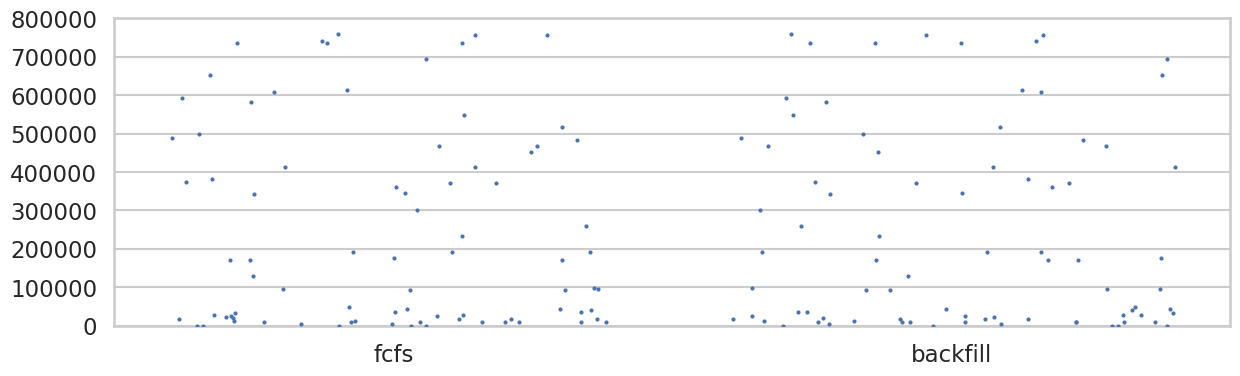

In [193]:
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'waiting_time']].nlargest(n=4000, columns='waiting_time') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='waiting_time', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('results/waiting-time_dist.pdf', bbox_inches='tight')

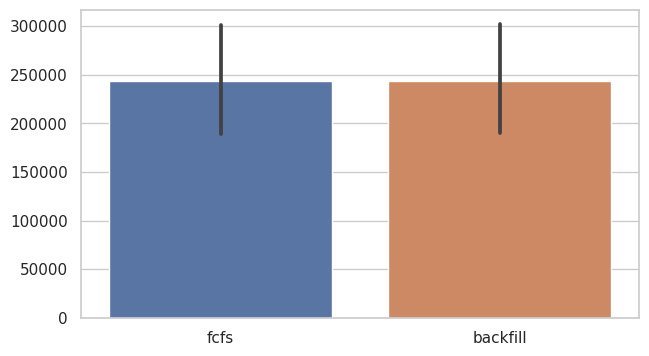

In [194]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=waiting_times, ax=ax)
fig.savefig('results/waiting-time_mean.pdf', bbox_inches='tight')

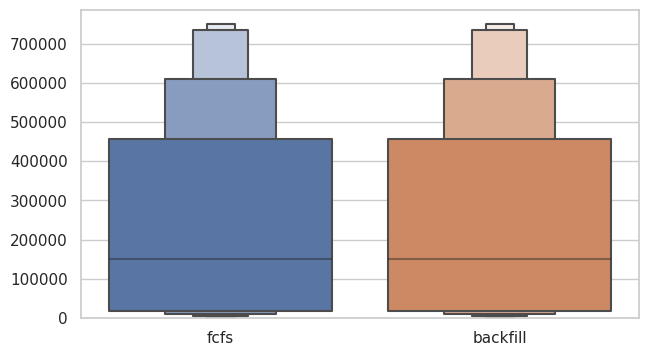

In [195]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=waiting_times, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('results/waiting-time_boxen.pdf', bbox_inches='tight')

In [196]:
turnaround_times = create_metric_df('turnaround_time')
turnaround_times.describe()

,fcfs,backfill
count,80.000000,80.000000
mean,254509.481675,254509.481675
std,260881.719795,260881.719795
min,5.672068,5.672068
25%,22735.492308,22735.492308
50%,171087.182988,171087.182988
75%,467929.971382,467929.971382
max,759920.355737,759920.355737


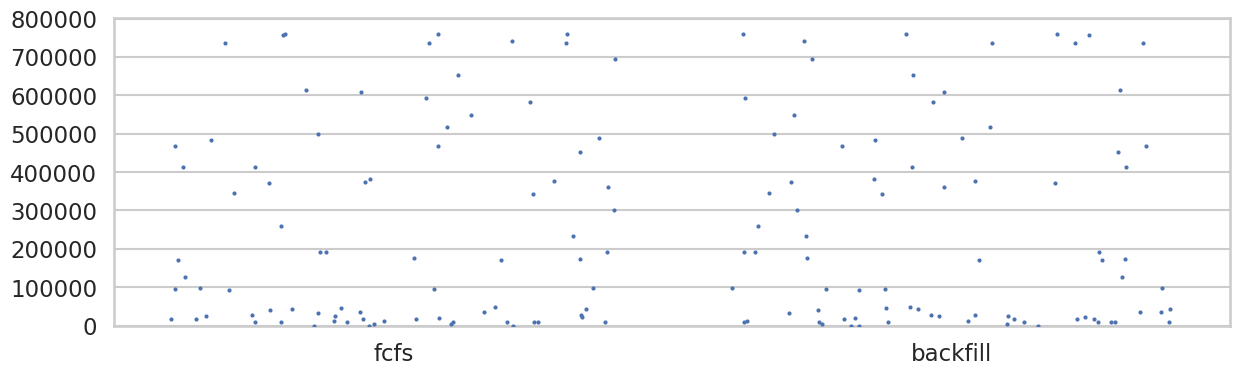

In [197]:
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'turnaround_time']].nlargest(n=4000, columns='turnaround_time') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='turnaround_time', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
#     ax.set_ylim(top=2.5*10**6)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('results/turnaround-time_dist.pdf', bbox_inches='tight')

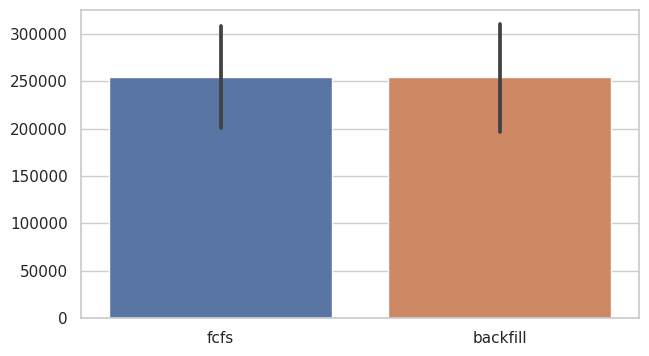

In [198]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=turnaround_times, ax=ax)
fig.savefig('results/turnaround-time_mean.pdf', bbox_inches='tight')

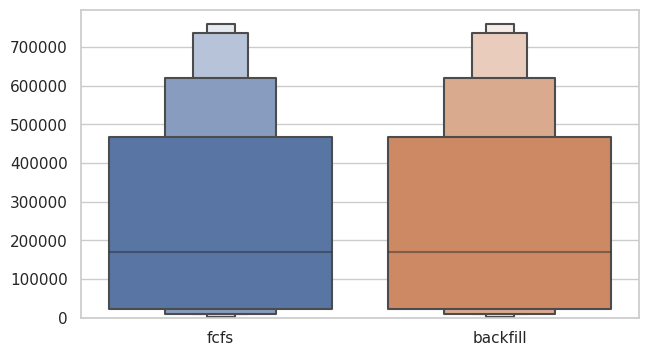

In [199]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=turnaround_times, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('results/turnaround-time_boxen.pdf', bbox_inches='tight')

In [200]:
slowdown = create_metric_df('stretch')
slowdown.describe()

,fcfs,backfill
count,80.000000,80.000000
mean,11766.248290,11766.248290
std,51089.722530,51089.722530
min,1.001181,1.001181
25%,6.744632,6.744632
50%,22.922929,22.922929
75%,121.861122,121.861122
max,356935.682429,356935.682429


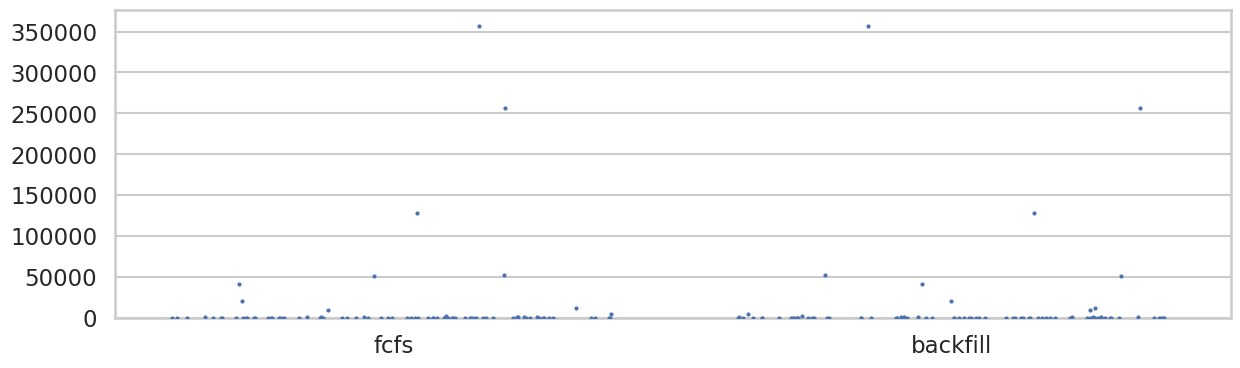

In [201]:
# Scatterplot, outliers
largest = pd.concat([metrics_df[metrics_df.schedule == schedule][['schedule', 'slowdown']].nlargest(n=4000, columns='slowdown') for schedule in schedule_names])
with sns.plotting_context('talk'):
    fig, ax = plt.subplots(figsize=(14.4,4))
    sns.stripplot(data=largest, x='schedule', y='slowdown', ax=ax, size=3, jitter=0.4)
    ax.set_ylim(0)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.savefig('results/slowdown_dist.pdf', bbox_inches='tight')

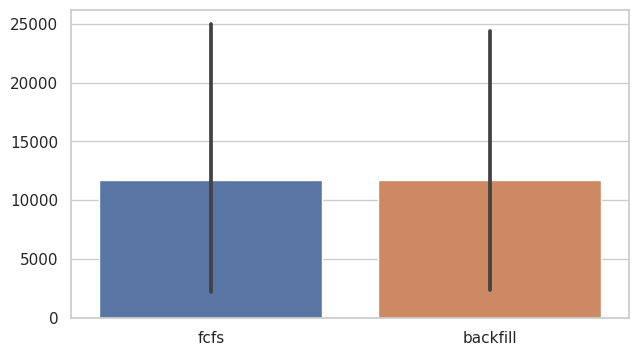

In [202]:
# Mean, logscale
fig, ax = plt.subplots(figsize=(7.2,4))
sns.barplot(data=slowdown, ax=ax)
fig.savefig('results/slowdown_mean.pdf', bbox_inches='tight')

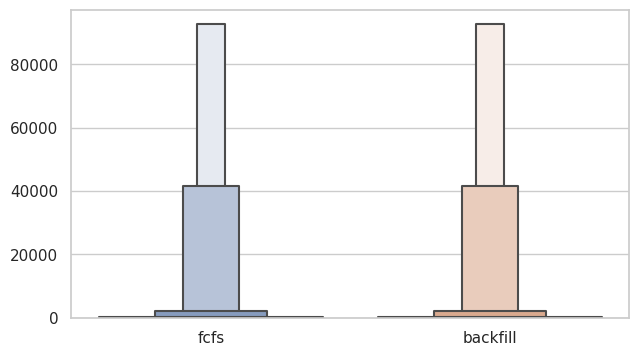

In [203]:
fig, ax = plt.subplots(figsize=(7.2,4))
sns.boxenplot(data=slowdown, k_depth=4, showfliers=False, ax=ax)
ax.set_ylim(0)
# ax.set_ylim(top=140000)
fig.savefig('results/slowdown_boxen.pdf', bbox_inches='tight')

In [204]:
# FCFS

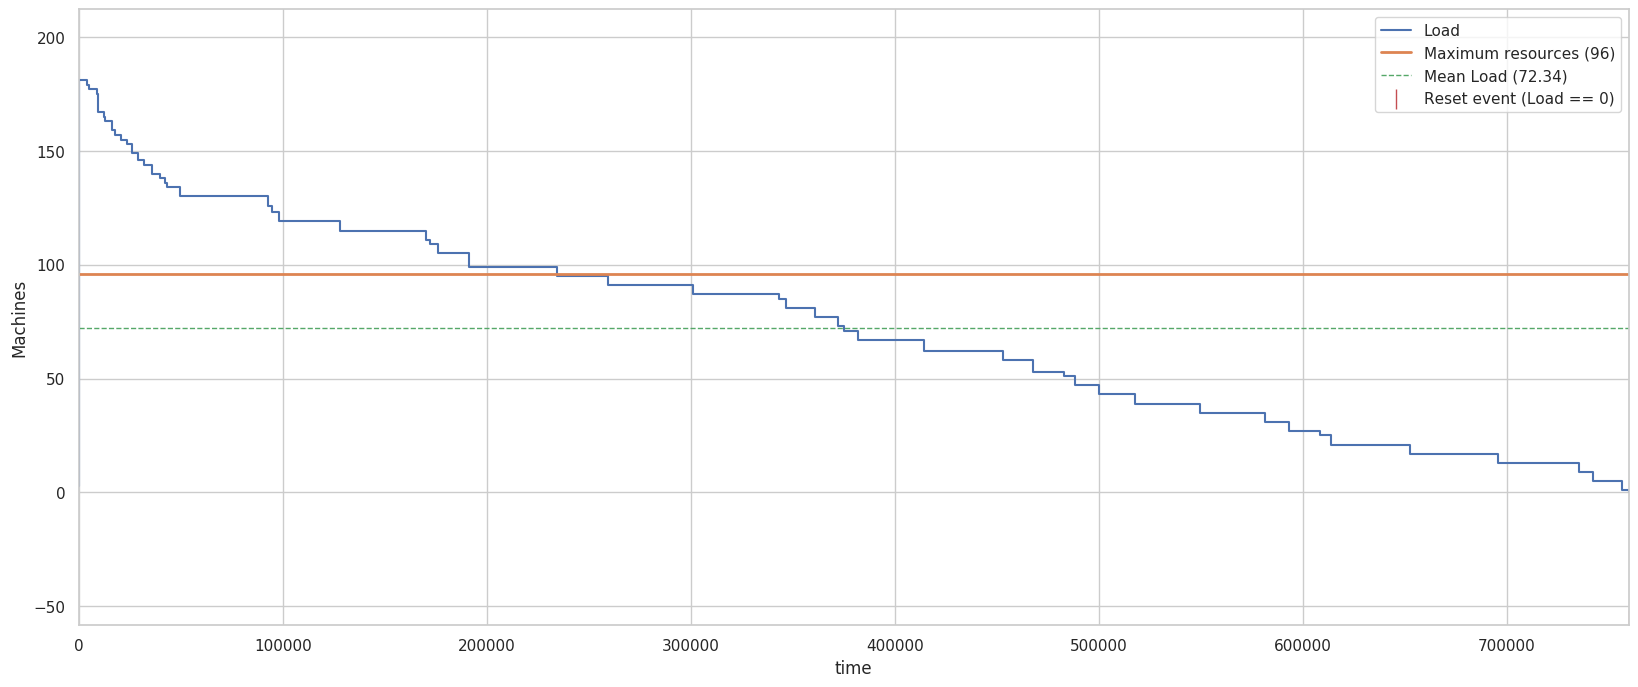

In [205]:
fig, ax = plt.subplots(figsize=(20,8))
evalys.visu.legacy.plot_load(jobsets['fcfs'].queue, nb_resources=96, ax=ax)

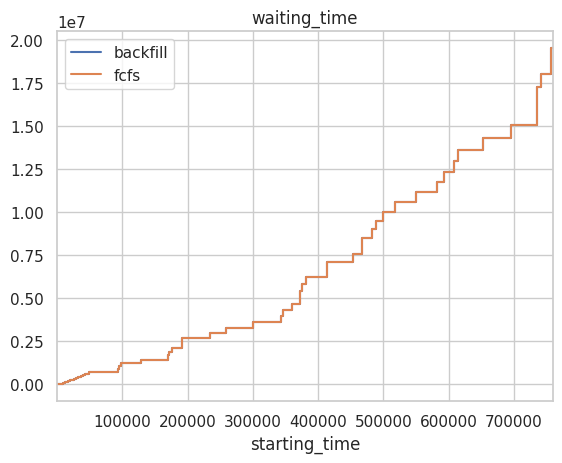

In [206]:
evalys.visu.legacy.plot_series('waiting_time', jobsets)